In [1]:
# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 


## Import Packages

In [2]:
#importing  packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

('This image is:', <type 'numpy.ndarray'>, 'with dimensions:', (540, 960, 3))


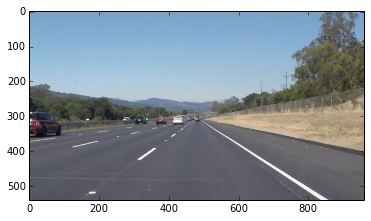

In [3]:

image = mpimg.imread('test_images/solidWhiteRight.jpg')
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  

## Ideas for Lane Detection Pipeline

**Some OpenCV functions that are used this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image


## Basic Functions

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #return cv2.cvtColor(img, cv2.COLOR_HLS2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def auto_canny(img):
    median = np.median(img)
    return cv2.Canny(img, int(0.66*median) , int(1.33*median))

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)




def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    ##Dynamic selection for different frame size
    height, width = img.shape[0:2]
    #print img.shape[0:2]
    vertices = np.array([[(100,540),(400, 330), (550, 330), (950,540)]], dtype=np.int32)
    #vertices  = np.array([[[width*0.1  , height*0.95],[width*0.45  , height*0.6],[width*0.9  , height*0.95],[width*0.6  , height*0.6]]],dtype = np.int32)
    
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    #plt.imshow(mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness= 10)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    lanes = find_lanes(img,lines)
    #draw_lines(line_img, lines)
    #print lanes
    draw_lines(line_img,lanes)
    return line_img



def filter_colour(img):
    img = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    w_filter = cv2.inRange(img, np.uint8([  0, 205,   0]), np.uint8([255, 255, 255]))
    y_filter = cv2.inRange(img, np.uint8([ 12,   0, 100]),  np.uint8([ 35, 255, 255]))
    final_mask = cv2.bitwise_or(w_filter, y_filter)
    return cv2.bitwise_and(img, img, mask = final_mask)
    #return img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, alpha =0.8, beta =1., lam =0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, alpha, img, beta, lam)

## Test Images

In [5]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidYellowCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'solidWhiteRight.jpg']

## Lane Finding Pipeline



In [6]:
# Pipeline 

def process_image(image):
    img = filter_colour(image)
    img = grayscale(img)
    img = gaussian_blur(img,13)
    img = auto_canny(img)
    img = region_of_interest(img)
    ##The parameters are set as per directions in the first review....
    img = hough_lines(img, rho = 1 , theta = np.pi/180 , threshold = 20 , min_line_len = 10, max_line_gap= 300)
    img = weighted_img(img,image)
    return img


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:52: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:56: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


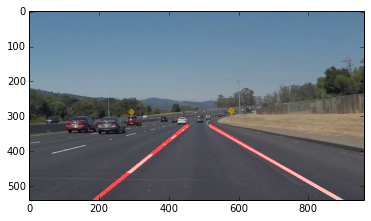

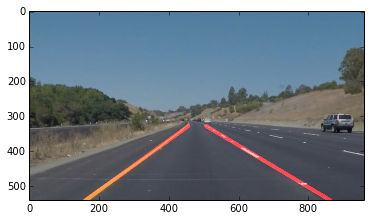

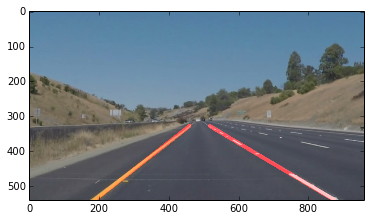

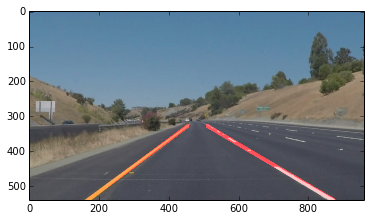

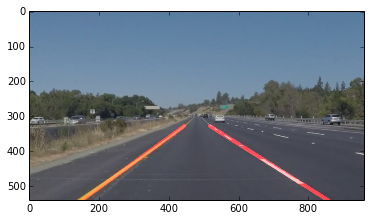

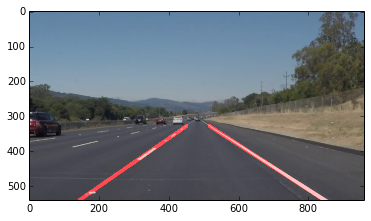

In [10]:
Output_dir = "final_img"
for image in os.listdir("test_images/"):
    img = mpimg.imread("test_images/" + image)
    img = process_image(img)
    plt.figure()
    plt.imshow(img,cmap = 'gray')    
    cv2.imwrite(Output_dir +"/" + image , img)

## Test on Videos
We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`


In [11]:
# Importing libraries needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
def process_image(image):
    img = filter_colour(image)
    img = grayscale(img)
    img = gaussian_blur(img,13)
    #img = canny(img,100,155)
    img = auto_canny(img)
    img = region_of_interest(img)
    img = hough_lines(img, rho = 1 , theta = np.pi/180 , threshold = 20 , min_line_len = 18 , max_line_gap= 310)
    img = weighted_img(img,image)
    return img

Let's try the one with the solid white lane on the right first ...

In [13]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


 99%|█████████▉| 125/126 [00:04<00:00, 23.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 5.24 s, sys: 556 ms, total: 5.8 s
Wall time: 5.84 s


Play the video inline, or if you prefer find the video in your filesystem 

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function
As per the challenge

In [16]:
def form_a_line(UP,LP,line):
    #using the equation y = mx + c
    slope , intercept  = line
    #print line
    x1 = int((UP - intercept) / slope)
    x2 = int ((LP - intercept) / slope)
    return (x1,int(UP),x2,int(LP))

def find_lanes(img,lines):
    """
    Find the lane from lines returned by hough probalistic transform
    Use slope to differentiate
    Has used weighted average to average the lines
    All the calculation are done using coordinate line equation 
    """
    left_lane_SI = []
    left_lane_length = []
    right_lane_SI = []
    right_lane_length = []
    if lines is None:
        return [[[0,0,0,0],[0,0,0,0]]]
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x1 == x2:
                continue #avoiding the condition of Infinte slope
            if y1 == y2:
                continue # avoiding zero slope
            length = np.sqrt((x2-x1)**2  + (y2-y1)**2)
            if length > 0:
                slope = float(y2-y1)/float(x2-x1)
                #print slope
                intercept = y1 - slope*x1
                if slope < 0 :
                    left_lane_SI.append((slope,intercept))
                    left_lane_length.append((length))
                else:
                    right_lane_SI.append((slope,intercept))
                    right_lane_length.append((length))
    #Weighted average
    # y = sum(L*x) / sum(L) 
    if len(right_lane_length) > 0:
        right_lane_product = np.dot(right_lane_length,right_lane_SI)
        right_lane_length_sum  =  np.sum(right_lane_length)
        right_lane = right_lane_product / right_lane_length_sum
    else:
        right_lane = None
    
    if len(left_lane_length) > 0:
        left_lane_product = np.dot(left_lane_length,left_lane_SI)
        left_lane_length_sum = np.sum(left_lane_length)
        left_lane = left_lane_product / left_lane_length_sum
    else:
        left_lane = None
    #print right_lane
    #print left_lane
    UP = img.shape[0]
    LP = img.shape[0]*0.61
    if right_lane != None:
        right_lane = form_a_line(UP,LP,right_lane)
    else:
        right_lane = [0,0,0,0]
    if left_lane != None:
        left_lane = form_a_line(UP,LP,left_lane)
    else:
        left_lane = [0,0,0,0]
        
    lane  = [[average_lanes(right_lane,True,first_flag),average_lanes(left_lane,False,first_flag)]]
    #print lane
    return lane
    
        

In [9]:
## Function added after the first review
previous_rigth_lane = np.zeros(4)
previous_left_lane = np.zeros(4)
first_flag = 0
def average_lanes(lane, flag,first_flag):
    if first_flag == 0 :
        if flag == True:  #for right lane
            if lane != [0,0,0,0]:
                previous_rigth_lane = np.copy(lane)
                first_flag += 1
        else:
            if lane != [0,0,0,0]:  #for left lane
                previous_left_lane = np.copy(lane)
                first_flag += 1
        
    else:
        if flag == True:  #for right lane
            if lane != [0,0,0,0]:
                lane = (np.array(lane) + previous_rigth_lane) /  2
                previous_rigth_lane = np.copy(lane)
        else:
            if lane != [0,0,0,0]:  #for left lane
                lane = (np.array(lane) + previous_left_lane) /  2
                previous_left_lane = np.copy(lane)
    return lane


In [17]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,3)
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


 99%|█████████▊| 75/76 [00:02<00:00, 27.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 3.19 s, sys: 306 ms, total: 3.49 s
Wall time: 3.65 s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge


In [21]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,3)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:21<00:00, 11.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 21.8 s, sys: 961 ms, total: 22.8 s
Wall time: 23.4 s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))